# MOML - Clustering

---

### Import de tous les modules nécessaires

In [55]:
%matplotlib inline
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.spatial.distance import pdist, squareform 
from sklearn.cluster import KMeans
from scipy.io import arff
import pandas as pd
import networkx as nx
import numpy as np
from numpy import linalg as LA

### Chargement et pré-traitement de la base de donées

Pour pouvoir utiliser la base de données, il nous faut en retirer:


*   Les lignes contenant des missing values
*   Les features inadaptées aux calculs (```"fruit", "daf", "site"```)

On transforme également la colonne cible depuis son format de chaîne de charactères vers un format entier.

In [56]:
data, meta = arff.loadarff("Squash.arff") #remplacer Squash.arff par le chemin du fichier qui contient la database sur votre machine

df = pd.DataFrame(data)
# on retire les rows avec des missing values
df.dropna(inplace=True)

# on retire les colonnes non numériques, dont on ne va pas se servir
del df["site"]
del df["daf"]
del df["fruit"]

# excellent : 0, ok : 1, not_acceptable : 2
df["Acceptability"] = df["Acceptability"].replace([b"excellent", b"ok", b"not_acceptable"], [0, 1, 2])

df.head() #premières valeurs pour avoir une idée des données

,weight,storewt,pene,solids,brix,a*,egdd,fgdd,groundspot_a*,glucose,fructose,sucrose,total,glucose+fructose,starch,sweetness,flavour,dry/moist,fibre,heat_input_emerg,heat_input_flower,Acceptability
0,1815.0,1717.0,8.3,22.3,10.6,22.5,651.0,262.0,7.71,18.93,18.71,20.00,57.65,37.64,92.77,667.0,748.6,610.1,376.9,847.0,458.0,0
1,1667.0,1590.0,8.4,21.6,11.3,19.9,651.0,262.0,7.12,20.24,18.36,22.38,60.98,38.60,85.10,823.6,817.8,670.9,308.4,721.0,458.0,0
2,1508.0,1437.0,7.0,19.8,11.2,20.2,651.0,262.0,10.58,20.73,19.58,18.63,58.94,40.31,70.29,740.5,837.8,693.7,331.5,847.0,458.0,1
3,1508.0,1422.0,6.6,19.1,10.6,21.0,651.0,262.0,2.97,24.33,20.57,13.58,58.48,44.90,63.79,697.5,780.8,784.4,408.4,847.0,458.0,1
4,1611.0,1504.0,8.0,16.3,10.1,23.9,772.0,372.0,0.48,21.37,16.45,20.05,57.87,37.82,27.87,740.5,746.5,744.5,590.5,968.0,568.0,1


# Clustering par KMeans


In [109]:
k = 3 # Nombre de clusters
model = KMeans(n_clusters=k)
model.fit(df)

#On stocke les prédictions dans une nouvelle colonne de la dataframe
df["km_label"] = model.labels_

Pour plot les données, on choisit deux features arbitraires : le poids et la saveur.

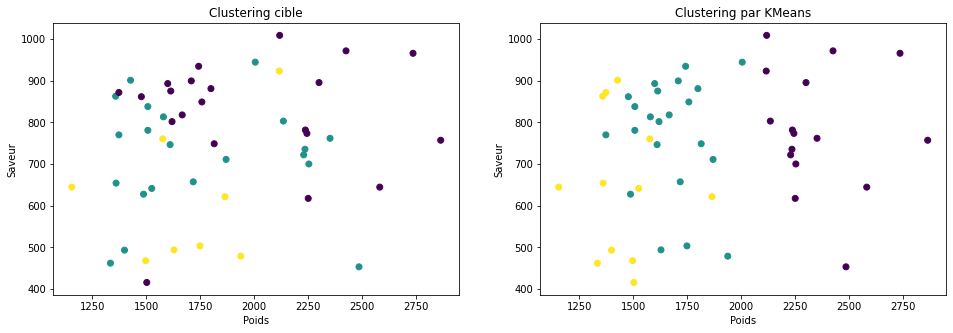

In [110]:
fig = plt.figure(figsize=(16,5))

# Plot du clustering cible
plt.subplot(121)
plt.scatter(df["weight"], df["flavour"], c=df["Acceptability"])
plt.xlabel("Poids")
plt.ylabel("Saveur")
plt.title("Clustering cible")

# Plot du clustering donné par KMeans
plt.subplot(122)
plt.scatter(df["weight"], df["flavour"], c=df["km_label"])
plt.xlabel("Poids")
plt.ylabel("Saveur")
plt.title("Clustering par KMeans")

plt.show()

In [111]:
# Calcul du taux de prédictions correctes

n = df.shape[0]
corrects = df.apply(lambda x: (x["Acceptability"] == x["km_label"]), axis=1)
n_correct = len(corrects[corrects == True].index)
print("Précision :", n_correct/n)

Précision : 0.44


# Matrices d'adjacence et de similarité

In [60]:
def dist_sq(x, y):
  """
  fonction qui calcule la distance au carré entre 2 points 
  
  x et y sont 2 vecteurs (1 x n) 
  """
  
  square_root_distance = distance.euclidean(x,y) #calcul la distance euclidienne sans mettre au carré
  resu = square_root_distance**2 # on met au carré
  return resu

In [61]:
def weight(x, y):
  """
  fonction qui calcule le poids entre 2 points connectés
  """
  d = dist_sq(x, y) # appel de la fonction qui calcule la distance entre 2 points
  resu = np.exp(-d/2) # calcul du poids avec la distance d'après la formule de similarité du cours (NB : ici on posera sigma = 1)
  return resu

In [62]:
def distance_matrix(data):
  """
  fonction qui calcule la matrice de distance entre les différents points, rend une matrice symétrique
  """
  return squareform(pdist(data.iloc[:], lambda x, y : dist_sq(x, y)))

In [63]:
def simil_no_epsilon(data):
  """
  fonction qui calcule la matrice de similarité sans critère epsilon,
  pour une utilisation par le spectral clustering

  Cette fonction implémente une normalisation des distances pour éviter 
  que l'exponentielle dans weight(x, y) n'écrase toutes les grandes distances sur 0
  """
  dist = distance_matrix(data)
  max_dist = np.amax(dist)
  dist = np.array([elem/max_dist for elem in dist])
  return squareform(pdist(dist, lambda x, y: weight(x, y)))

In [64]:
def adjacency_and_similarity_matrix(data, epsilon, bypass=False) : 
    """
    fonction qui définit si 2 points sont connectés ou non sur la base de leur distance ou de leur similarité,
    retourne les matrices d'adjacence et de similarité

    epsilon : seuil arbitraire pour savoir si 2 point sont connectés ou non sur la base de leur distance
    bypass = si True, néglige le seuil epsilon (deprecated, utiliser le simil_no_epsilon)
    """
    mat_dist = distance_matrix(data) # appel fonction qui calcule la matrice de distance entre chaque points
    n= mat_dist.shape[0] # nombre de ligne de la data frame , i.e : nombre de points
    adja= np.zeros((n,n)) #défintion de la matrice d'adjacence , qui contiendra des 0 ou des 1 
    simi = np.zeros((n,n))# définition de la matrice de similarité , qui contiendra des poids entre 0 et 1 
    
    for i in range (0,n):
        for j in range (i,n):
          if ( mat_dist[i,j] < epsilon) or bypass:  # critère de connectivité 
            adja[i, j] = 1
            adja[j, i] = 1
            vec_i = data.iloc[[i],:]
            vec_j = data.iloc[[j],:]
            simi[i, j] = weight(vec_i,vec_j)
            simi[j, i] = simi[i, j]
    return adja, simi 

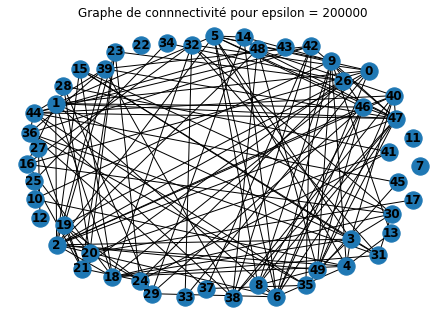

In [99]:
#Graph
epsilon = 200000
adja,simi = adjacency_and_similarity_matrix(df,epsilon)
n = simi.shape[0]
G = nx.Graph()
for i in range(0,n):
  G.add_nodes_from([i])

for i in range(0,n):
  for j in range(0,n):
    if adja[i,j]==1 :
      G.add_edge(i, j, weight = simi[i,j])

nx.draw(G, with_labels=True, font_weight='bold')
plt.title(f"Graphe de connnectivité pour epsilon = {epsilon}")
plt.show()

# Spectral clustering

In [66]:
def Ls(W):
  '''Construction de la matrice de Laplace 
  et de la matrice de Laplace normalisée
  '''
  D = np.sum(W, axis=1)             # degrés
  D_ = np.diag(np.power(D, -1/2))             # D^(-1/2)
  L = np.diag(D) - W                  # Matrice de Laplace
  L_norm = np.dot(D_, np.dot(L, D_))  # L normalisée

  return L_norm

In [67]:
def spectral_clustering(W, nbCluster) :
  """
  Fonction de la methode du spectral clustering.
  Entrées : W = matrice de similarité / nbCluster = nombre de clusters souhaité
  Sortie : Renvoie une liste d'array comportant les indices des pts du même cluster.

  """
  #On construit la matrice laplacienne
  L_norm = Ls(W)

  #Trier les vecteurs propres dans l'ordre croissant des val. propres
  eigenValues, eigenVectors = LA.eigh(L_norm)  
  indice = eigenValues.argsort() 
  eigenValues, eigenVectors = eigenValues[indice], eigenVectors[:,indice]
  V = eigenVectors[:,:nbCluster]


  #On applique la méthode kmean sur les lignes de V
  model = KMeans(n_clusters=nbCluster).fit(V)
  return model.labels_ 


In [100]:
df["sc_label"] = spectral_clustering(simil_no_epsilon(df), 3)

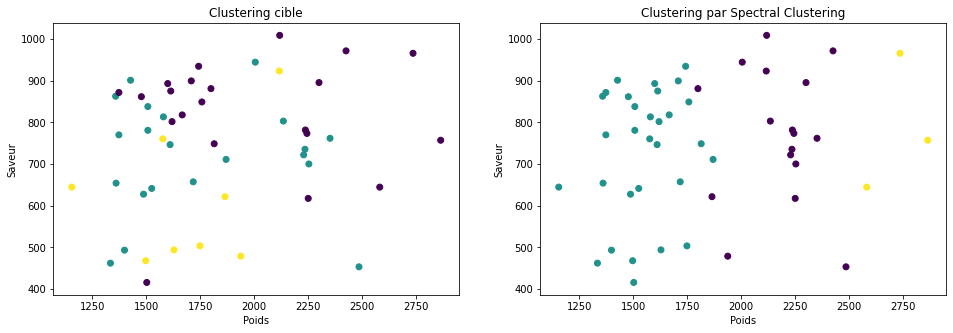

In [101]:
fig = plt.figure(figsize=(16,5))

# Plot du clustering cible
plt.subplot(121)
plt.scatter(df["weight"], df["flavour"], c=df["Acceptability"])
plt.xlabel("Poids")
plt.ylabel("Saveur")
plt.title("Clustering cible")

# Plot du clustering donné par KMeans
plt.subplot(122)
plt.scatter(df["weight"], df["flavour"], c=df["sc_label"])
plt.xlabel("Poids")
plt.ylabel("Saveur")
plt.title("Clustering par Spectral Clustering")

plt.show()

In [102]:
# Calcul du taux de prédictions correctes

n = df.shape[0]
corrects = df.apply(lambda x: (x["Acceptability"] == x["sc_label"]), axis=1)
n_correct = len(corrects[corrects == True].index)
print("Précision :", n_correct/n)

Précision : 0.42


# Unsupervised learning: Méthodes pour choisir le nombre de clusters

## Eigengap method

In [71]:
def eigengap(Ls):
  """méthode qui renvoie l'indice du plus grand écart
  entre les valeurs propres de la matrice de laplace
  
  Cet indice est cense etre le meilleur nombre de clusters
    
  Arguments:
      Ls {numpy array} -- [matrice de laplace]
  """
  w, _ = LA.eigh(Ls) # Les valeurs propres de la matrice de laplace
  w = np.sort(w) # triees dans l'ordre croissant

  #calcul des écarts en valeur absolue 
  gaps = np.zeros((len(w))) 
  for i in range(len(w) - 1):
    gaps[i] = abs(w[i]-w[i+1])
  
  n_vals = 20 #nb des premieres valeurs propres à plot
  fig = plt.figure(figsize=(10,5))
  plt.plot(np.arange(n_vals), w[:n_vals], "x")
  plt.xticks(np.arange(n_vals))
  plt.xlabel("Indice de la valeur propre")
  plt.ylabel("Valeur propre")
  plt.title("Eigengaps")
  
  #indice du plus grand écart (+1 pour le nb de clusters)
  return np.argmax(gaps)+1

k qui maximise l'eigengap:  1


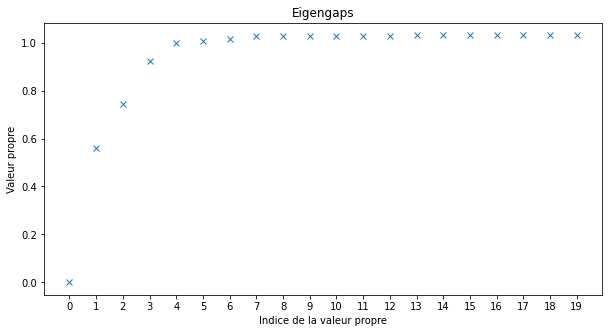

In [72]:
print("k qui maximise l'eigengap: ",eigengap(Ls(simil_no_epsilon(df))))

## Méthode Elbow

In [73]:
def elbow(data):
  """méthode qui plot les variances d'un clustering en Kmeans
    pour des valeurs de k allant de 1 à 10
    
    L'elbow method prescrit de choisir le k qui correspond à un "coude" dans le plot
    
    Arguments:
        data {[DataFrame} -- [les données sur lesquelles effectuer Kmeans]
    """
  vars = []
  for k in range(1, 10):
    model = KMeans(n_clusters=k)
    model.fit(data)
    vars.append(model.inertia_) # variances
  plt.figure(figsize=(8,4))
  plt.plot(np.arange(1, 10), vars)
  plt.xlabel("Nombre de clusters")
  plt.ylabel("Variance")
  plt.title("Méthode Elbow")
  plt.show()

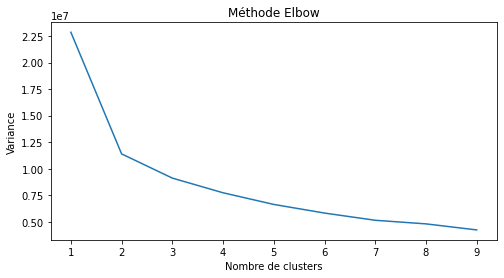

In [74]:
elbow(df)

## Silhouette method

In [78]:
def compute_Si(point, cluster, non_neighbors, k):
  """Calcul du score de silhouette d'un point donné
  Note: un point dans cluster de taille 1 a toujours un score de 0
  
  Arguments:
    point {DataFrame} -- [le point dont on calcule le score]
    cluster {DataFrame} -- [le cluster auquel appartient le point]
    non_neighbors {DataFrame} -- [tous les points des autres clusters]
    k {int} -- [nb de clusters]
    
  Returns:
    number -- [le score de silhouette de point]
  """
  if cluster.shape[0] == 1:
    ai = 0
  else:
    dists_inter = squareform(pdist(pd.concat([point, cluster])))
    s_inter = np.sum(dists_inter[0,:]) # somme des distances du point à ses collègues de cluster
    ai = s_inter/(cluster.shape[0] - 1) # moyenne, avec /n-1 puisque le point lui-même ne compte pas
    
  dists_exter = []
  for i in range(k):
    if i == point["km_label"].iat[0]:
      # on passe ce tour de boucle,
      # car other_cluster (cf definition ci-dessous) serait vide
      # pour i le label de point
      # puisque non_neighbors ne contient pas les points du cluster de point
      continue
    other_cluster = non_neighbors[non_neighbors["km_label"] == i] # les points du cluster i
    if other_cluster.shape[0] == 1:
      dists_exter_k = ai # si ai s'avere etre le min des distances, Si sera nul
    else:
      # cf le calcul de ai, similaire
      dists_exter_k = np.sum(squareform(pdist(pd.concat([point, other_cluster])))[0,:])
      dists_exter_k = dists_exter_k/other_cluster.shape[0]

    dists_exter.append(dists_exter_k)

  bi = np.amin(np.array(dists_exter))
  if ai == bi:
    return 0
  elif ai < bi:
    return 1 - ai/bi
  return 1 - bi/ai

In [79]:
def silhouette(dataframe):
  """Calcule le meilleur score de silhouette
  de différents clustering Kmeans pour k allant de 2 à 10
  
  Plus le score est proche de 1, meilleur est le clustering
  Note: cette fonction plot aussi les valeurs du score
    
  Arguments:
    dataframe {DataFrame} -- [les données pour le clustering]
    
  Returns:
    [int] -- [le meilleur k pour le clustering]
  """
  data = dataframe.copy() # parce que l'on va rajouter/modifier des colonnes
  Sk = [] # liste qui stockera les scores moyens des k-clusterings
  for k in range(2, 11):
    Si= [] # liste qui stockera les scores des points dans le clustering actuel
    model = KMeans(n_clusters=k)
    model.fit(data)
    data["km_label"] = model.labels_ # labels predits
    for ind in range(data.shape[0]):
      point = data.iloc[[ind]]
      label_pt = point["km_label"].iat[0]
      neighbors = data[data["km_label"] == label_pt] # les points du cluster auquel appartient le point
      non_neighbors = data[data["km_label"] != label_pt] # les autres points
            
      Si.append(compute_Si(point, neighbors, non_neighbors, k))

    Sk.append(np.mean(np.array(Si)))     

  plt.plot(np.arange(2, 11), Sk)
  plt.title("Score de silhouette moyen pour k clusters")
  plt.xlabel("k")
  plt.ylabel("Score")
  plt.show()
  return np.argmax(np.array(Sk)) + 2 # +2 car le range va de 2 à 11, et les indices de listes commencent à 0

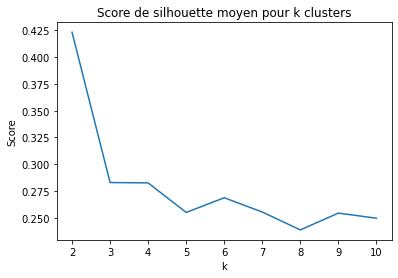

Nombre recommandé de clusters selon la méthode silhouette : 2


In [80]:
print("Nombre recommandé de clusters selon la méthode silhouette :", silhouette(df))